In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from dotenv import load_dotenv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path
dotenv_path = Path('hyperparameters.env')  # Specify the path to your .env file
load_dotenv(dotenv_path=dotenv_path)

True

In [3]:
Filename_address = os.getenv("FILE_ADDRESS")
Output_address = os.getenv("OUTPUT_ADDRESS")

lag = int(os.getenv("LAG", 20))
epochs = int(os.getenv("EPOCHS", 10))
learning_rate = float(os.getenv("LEARNING_RATE", 0.001))
batch_size = int(os.getenv("BATCH_SIZE", 32))
number_nodes = int(os.getenv("NUMBER_NODES", 50))
days = int(os.getenv("Prediction_days", 800))
n = int(os.getenv("NN_LAGS", 20))

In [4]:
# if len > 1 then use bar plot

In [5]:
Filename_address= "sample_data.csv"
Filename_address

'sample_data.csv'

In [6]:
def evaluate_accuracy(predictions_df, actuals_df, target_columns):
    # Initialize lists to store the metrics for each target column
    mae_list = []
    mse_list = []
    rmse_list = []
    r2_list = []

    # Loop through each target column and calculate the metrics
    for col in target_columns:
        # Extract the predicted and actual values for the current column
        predicted_values = predictions_df[col].values
        actual_values = actuals_df[col].values

        # Calculate MAE, MSE, RMSE, and R² for the current column
        mae = mean_absolute_error(actual_values, predicted_values)
        mse = mean_squared_error(actual_values, predicted_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual_values, predicted_values)

        # Append the metrics to their respective lists
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)

        # Print the metrics for the current column
        print(f'Metrics for {col}:')
        print(f'  MAE: {mae:.3f}')
        print(f'  MSE: {mse:.3f}')
        print(f'  RMSE: {rmse:.3f}')
        print(f'  R²: {r2:.3f}')
        print('----------------------------')

    return mae_list, mse_list, rmse_list, r2_list

In [7]:
def data_loader():
    data = pd.read_csv(Filename_address, index_col="Date", parse_dates=True)
    data = data.dropna()
    print(f"Original data shape: {data.shape}")
    return data

In [8]:
def data_allocation(data):
    train_len_val = len(data) - days
    train, test = data[close].iloc[0:train_len_val], data[close].iloc[train_len_val:]
    print(f"Training set size: {len(train)}")
    print(f"Test set size: {len(test)}")
    return train, test

In [9]:
def apply_transform(data, n):
    middle_data, target_data = [], []
    for i in range(n, len(data)):
        middle_data.append(data[i-n:i])
        target_data.append(data[i])
    middle_data = np.array(middle_data).reshape((len(middle_data), n, 1))
    target_data = np.array(target_data)
    return middle_data, target_data

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
data =  data_loader()
data.head(20)

Original data shape: (5032, 7)


,Metal,Plastic,Organic,Paper,Hazardous,E-Waste,ID
Date,,,,,,,
2014-08-26,0.47900,0.48725,0.47725,0.48625,0.464927,269636000,1
2014-08-27,0.48325,0.48700,0.48000,0.48075,0.459668,182972000,1
2014-08-28,0.47975,0.48575,0.47825,0.48475,0.463493,179704000,1
2014-08-29,0.48650,0.48725,0.48125,0.48625,0.464927,207932000,1
2014-09-02,0.48750,0.48750,0.48300,0.48750,0.466122,192636000,1
2014-09-03,0.49000,0.49375,0.48675,0.49200,0.470425,259456000,1
2014-09-04,0.49125,0.50375,0.49100,0.50075,0.478791,491832000,1
2014-09-05,0.50025,0.50250,0.49600,0.49925,0.477357,253792000,1
2014-09-08,0.49875,0.49975,0.49275,0.49475,0.473055,319288000,1


In [12]:
from torch.utils.data import Dataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch

class TimeSeriesDataset(Dataset):
    def __init__(self, df, target_cols, n_steps=5):
        self.df = df
        self.target_cols = target_cols
        self.n_steps = n_steps
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.df_scaled = pd.DataFrame(self.scaler.fit_transform(self.df), columns=self.df.columns)

        # Prepare the shifted columns and scale the data
        self.features, self.targets = self.prepare_data()

    def prepare_data(self):
        df = dc(self.df_scaled)
        features = []
        targets = []

        # Shift the columns for each target column
        for i in range(1, self.n_steps + 1):
            shifted_cols = {f'{col}(t-{i})': df[col].shift(i) for col in self.target_cols}
            df = df.assign(**shifted_cols)

        # Drop rows with NaN values created by the shifting
        df.dropna(inplace=True)

        # Prepare the input features and targets
        feature_cols = [f'{col}(t-{i})' for col in self.target_cols for i in range(1, self.n_steps + 1)]
        features = df[feature_cols].values.reshape(-1, self.n_steps, len(self.target_cols))

        # Prepare the targets (current value for each target column)
        targets = df[self.target_cols].values

        # Print the features and targets for validation
        #print("\nFirst few rows of Features:")
        #print(features[:5])  # Print the first 5 feature rows
        #print("\nFirst few rows of Targets:")
        #print(targets[:5])  # Print the first 5 target rows

        return features, targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Retrieve the sample
        X = self.features[idx]  # Shape: (n_steps, num_features)
        y = self.targets[idx]  # Shape: (num_target_columns)

        # Convert to torch tensors
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y


In [13]:
target_columns = list(data.columns)
target_columns.remove('ID')
target_columns

['Metal', 'Plastic', 'Organic', 'Paper', 'Hazardous', 'E-Waste']

In [14]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(data, columns):
    """
    Scale the specified columns in the data using MinMaxScaler.
    """
    scalers = {}
    scaled_data = data.copy()

    # Initialize a single MinMaxScaler for all columns to scale together
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Fit the scaler to the specified columns and transform them
    scaled_data[columns] = scaler.fit_transform(data[columns])

    # Store the scaler for inverse transformations later
    scalers['scaler'] = scaler

    return scaled_data, scalers

In [15]:
lookback = 7 #look back


dataset = TimeSeriesDataset(df = data, target_cols= target_columns, n_steps= lookback) #target_columns
X, y = dataset[1]
print("\nFirst Sample (X, y):")
print("X:", X)
print("y:", y)


First Sample (X, y):
X: tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9581],
        [-0.9101, -0.9569, -0.9704, -0.9673, -0.9730, -0.9723]])
y: tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9449])


In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# model = LSTM(1, 60, 6)
# model.to(device)
# model
input_size = len(target_columns)  # Number of features per time step
hidden_size = 60  # Number of LSTM units in the hidden layer
num_stacked_layers = 6  # Number of stacked LSTM layers
output_size = len(target_columns)  # Number of target columns

# Initialize the LSTM model
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers, output_size=output_size)
model.to(device)

LSTM(
  (lstm): LSTM(6, 60, num_layers=6, batch_first=True)
  (fc): Linear(in_features=60, out_features=6, bias=True)
)

In [18]:
zip_codes = data['ID'].unique()

# Hyperparameters
lookback = 7
batch_size = 8
input_size = len(target_columns)
hidden_size = 60
num_stacked_layers = 6
output_size = len(target_columns)
learning_rate = 0.001
num_epochs = 50

for zip_code in zip_codes:
    print(f"Training model for Zip Code: {zip_code}")
    
    # Filter data for the current zip code
    filtered_data = data[data['ID'] == zip_code].drop(columns=['ID'])
    
    # Apply resampling and forward filling for this zip code
    filtered_data = filtered_data.resample('D').asfreq()
    filtered_data = filtered_data.fillna(method='ffill')
    
    # Scale the data for this zip code
    #scaled_data, scaler = scale_data(filtered_data, target_columns)
    
    # Create the dataset and DataLoader for this zip code
    dataset = TimeSeriesDataset(df=filtered_data, target_cols=target_columns, n_steps=lookback)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model for this zip code
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers, output_size=output_size)
    model.to(device)
    
    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training and validation loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        all_predictions = []
        all_actuals = []

        with torch.no_grad():
            for batch_index, batch in enumerate(test_loader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                
                output = model(x_batch)
                loss = loss_function(output, y_batch)
                running_val_loss += loss.item()
                
                all_predictions.append(output.cpu().numpy())
                all_actuals.append(y_batch.cpu().numpy())

        avg_val_loss = running_val_loss / len(test_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}')
        print('***************************************************')
        
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_actuals = np.concatenate(all_actuals, axis=0)
        
        predictions_df = pd.DataFrame(all_predictions, columns=target_columns)
        actuals_df = pd.DataFrame(all_actuals, columns=target_columns)
        
        # Optionally save the predictions and actuals for analysis
        # predictions_df.to_csv(f'predictions_{zip_code}_epoch_{epoch+1}.csv')
        # actuals_df.to_csv(f'actuals_{zip_code}_epoch_{epoch+1}.csv')
    
    # Save the model weights for this zip code
    model_path = f"model_LSTM_weights_{zip_code}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model training for Zip Code {zip_code} complete and saved successfully.\n")


Training model for Zip Code: 1
Epoch 1/50, Training Loss: 0.0509
Epoch 1/50, Validation Loss: 0.0044
***************************************************
Epoch 2/50, Training Loss: 0.0048
Epoch 2/50, Validation Loss: 0.0048
***************************************************
Epoch 3/50, Training Loss: 0.0047
Epoch 3/50, Validation Loss: 0.0053
***************************************************
Epoch 4/50, Training Loss: 0.0048
Epoch 4/50, Validation Loss: 0.0046
***************************************************
Epoch 5/50, Training Loss: 0.0045
Epoch 5/50, Validation Loss: 0.0044
***************************************************
Epoch 6/50, Training Loss: 0.0045
Epoch 6/50, Validation Loss: 0.0045
***************************************************
Epoch 7/50, Training Loss: 0.0045
Epoch 7/50, Validation Loss: 0.0043
***************************************************
Epoch 8/50, Training Loss: 0.0045
Epoch 8/50, Validation Loss: 0.0044
*********************************************

In [19]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

def evaluate_model(model, test_loader, scaler, target_columns, device):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    all_predictions = []
    all_actuals = []

    loss_function = torch.nn.MSELoss()

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Make predictions
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_val_loss += loss.item()

            # Collect predictions and actual values
            all_predictions.append(output.cpu().numpy())
            all_actuals.append(y_batch.cpu().numpy())

    # Calculate average validation loss
    avg_val_loss = running_val_loss / len(test_loader)

    # Concatenate all predictions and actuals
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)

    # Inverse transform the predictions and actuals to original scale
    all_predictions = scaler.inverse_transform(all_predictions)
    all_actuals = scaler.inverse_transform(all_actuals)

    # Convert to DataFrames for easy comparison
    predictions_df = pd.DataFrame(all_predictions, columns=target_columns)
    actuals_df = pd.DataFrame(all_actuals, columns=target_columns)

    return avg_val_loss, predictions_df, actuals_df

# Example usage for evaluating the model for each zip code
zip_codes = data['ID'].unique()

for zip_code in zip_codes:
    print(f"Evaluating model for Zip Code: {zip_code}")

    # Filter data for the current zip code
    filtered_data = data[data['ID'] == zip_code].drop(columns=['ID'])
    
    # Apply resampling and forward filling for this zip code
    filtered_data = filtered_data.resample('D').asfreq()
    filtered_data = filtered_data.fillna(method='ffill')
    
    # Scale the data for this zip code
    scaled_data, scaler = scale_data(filtered_data, target_columns)
    
    # Create the dataset and DataLoader for this zip code
    dataset = TimeSeriesDataset(df=scaled_data, target_cols=target_columns, n_steps=lookback)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers, output_size=output_size)
    
    # Load the model weights for this zip code
    model_path = f"model_LSTM_weights_{zip_code}.pth"
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # Evaluate the model
    avg_val_loss, predictions_df, actuals_df = evaluate_model(model, test_loader, scaler['scaler'], target_columns, device)

    print(f'Validation Loss for Zip Code {zip_code}: {avg_val_loss:.4f}')
    print(f'Predictions for Zip Code {zip_code}:\n', predictions_df.head())
    print(f'Actual values for Zip Code {zip_code}:\n', actuals_df.head())
    
    # Optionally save the predictions and actuals for analysis
    # predictions_df.to_csv(f'predictions_{zip_code}_evaluation.csv')
    # actuals_df.to_csv(f'actuals_{zip_code}_evaluation.csv')


Evaluating model for Zip Code: 1
Validation Loss for Zip Code 1: 0.0022
Predictions for Zip Code 1:
       Metal   Plastic   Organic     Paper  Hazardous      E-Waste
0  1.431548  1.452565  1.526202  1.451436   1.518521  267013376.0
1  1.441704  1.459704  1.526804  1.458075   1.529197  256152096.0
2  1.432906  1.463518  1.551793  1.469418   1.522445  298508576.0
3  1.558732  1.656772  1.726884  1.803467   1.727535  497447584.0
4  1.395726  1.434477  1.529177  1.444846   1.485204  321264640.0
Actual values for Zip Code 1:
       Metal   Plastic   Organic     Paper  Hazardous      E-Waste
0  0.487500  0.487499  0.482999  0.487498   0.466124  192636000.0
1  0.490001  0.493751  0.486748  0.492002   0.470426  259455952.0
2  0.491251  0.503750  0.491001  0.500751   0.478790  491832032.0
3  0.500248  0.502500  0.496001  0.499248   0.477356  253791952.0
4  0.500248  0.502500  0.496001  0.499248   0.477356  253791952.0
Evaluating model for Zip Code: 2
Validation Loss for Zip Code 2: 0.0030
Pred

Evaluating model for Zip Code: 1
Validation Loss for Zip Code 1: 0.0022


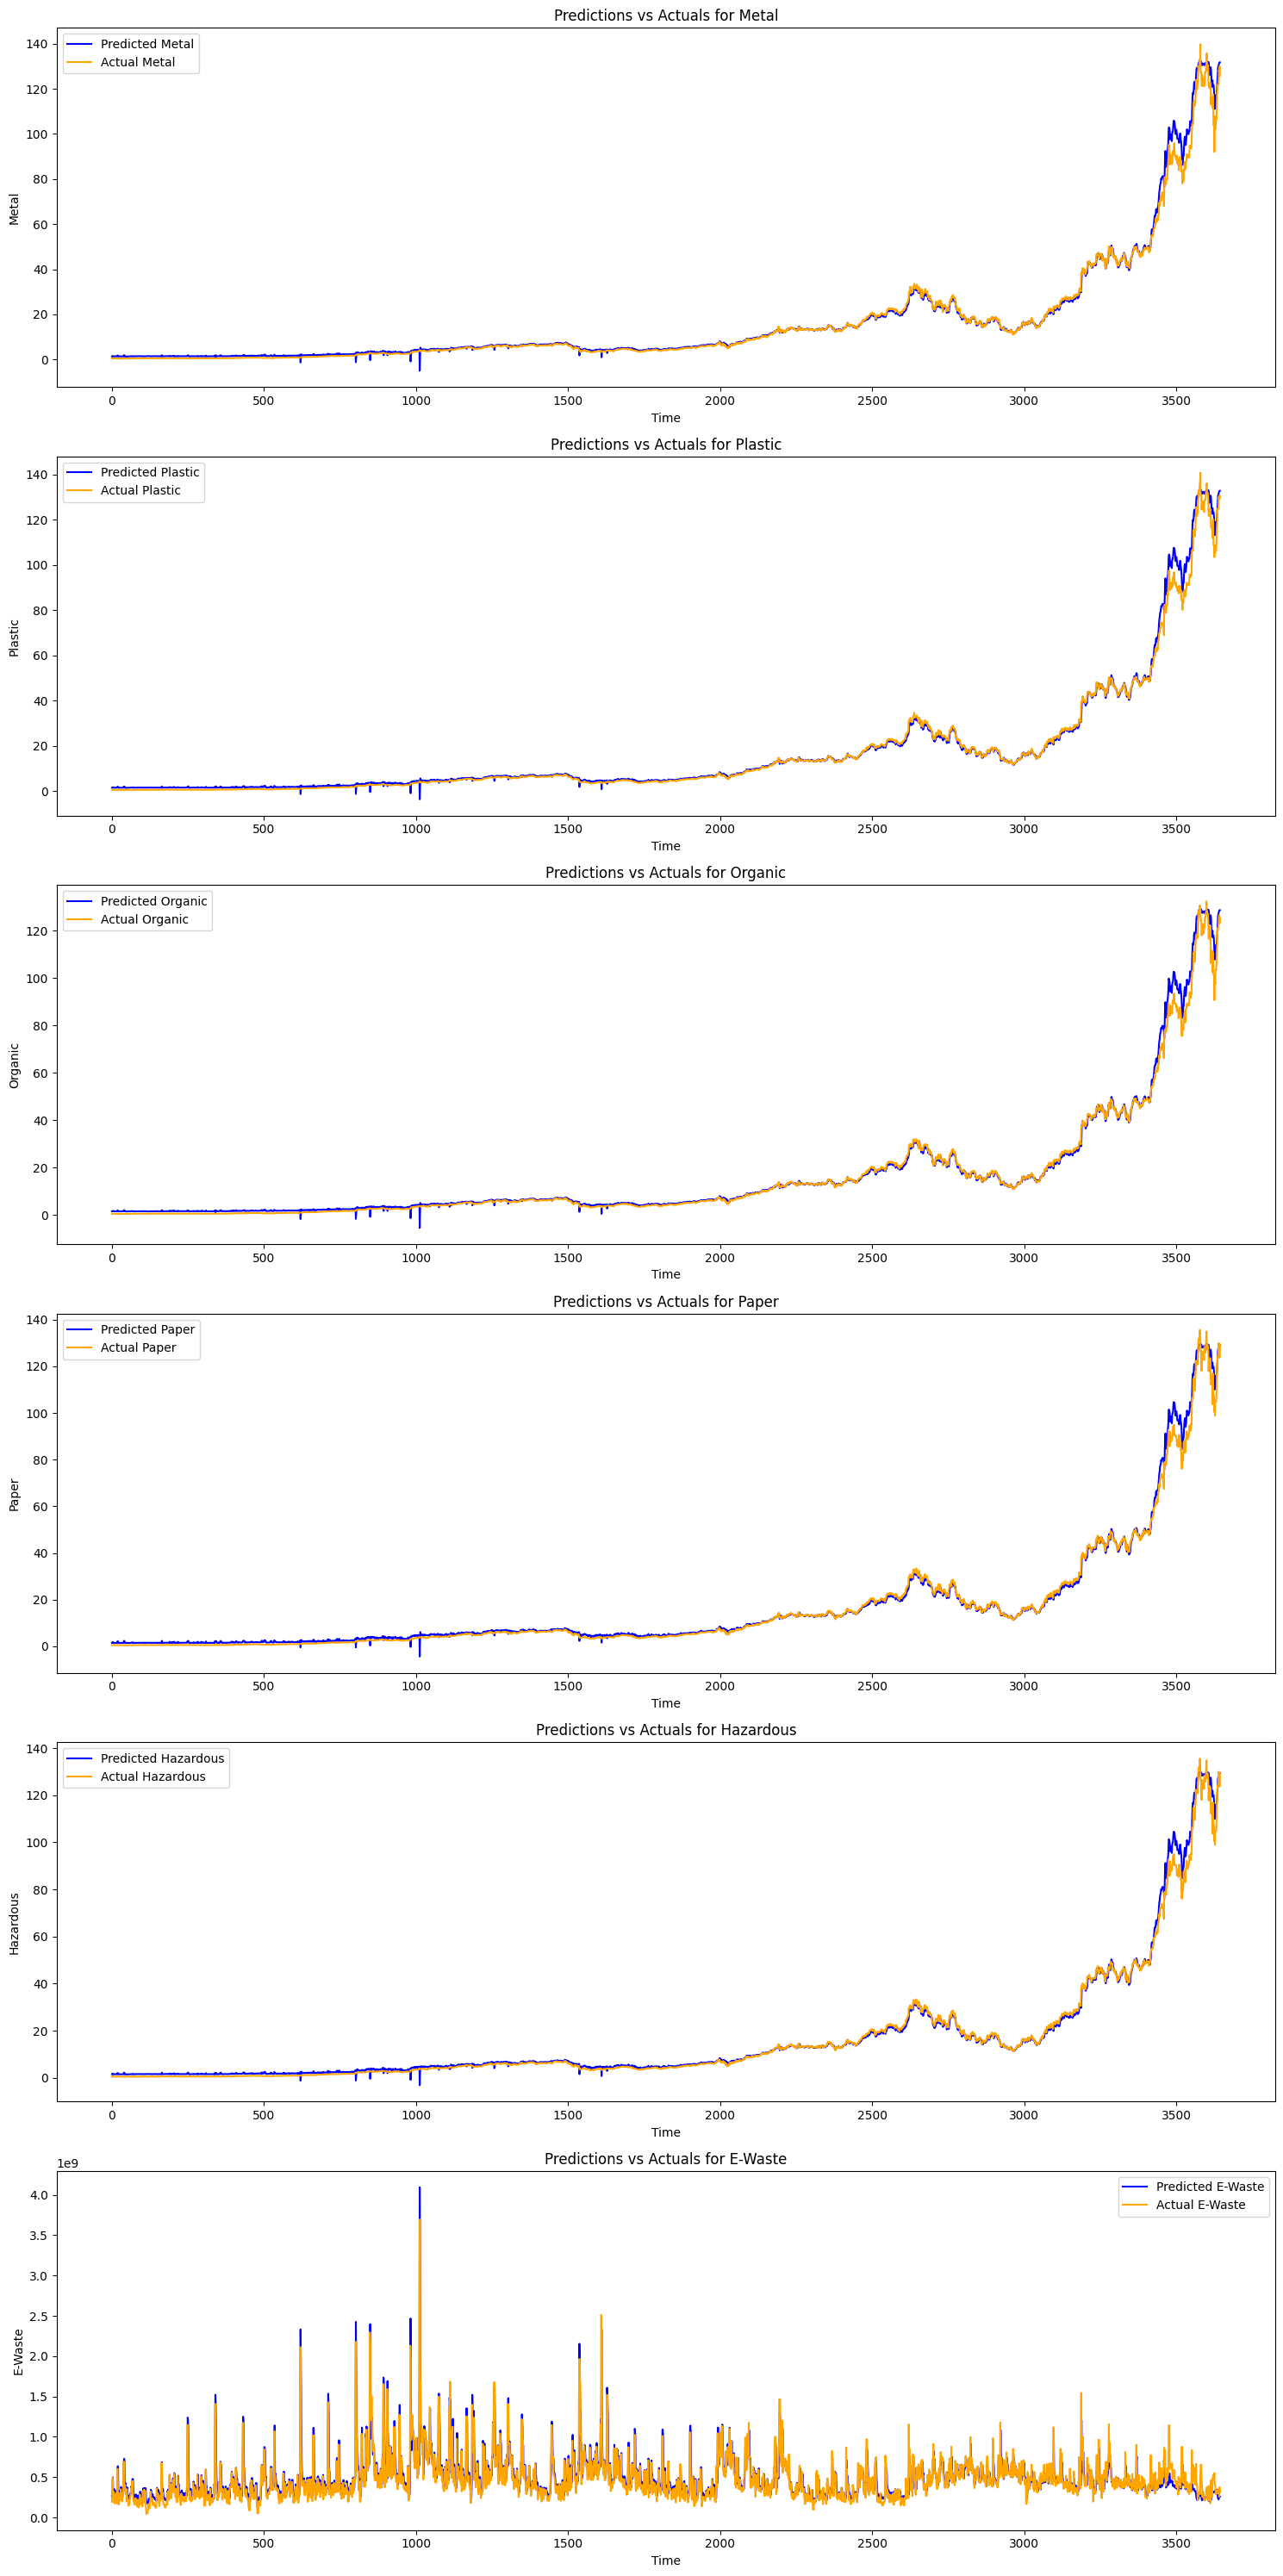

Evaluating model for Zip Code: 2
Validation Loss for Zip Code 2: 0.0030


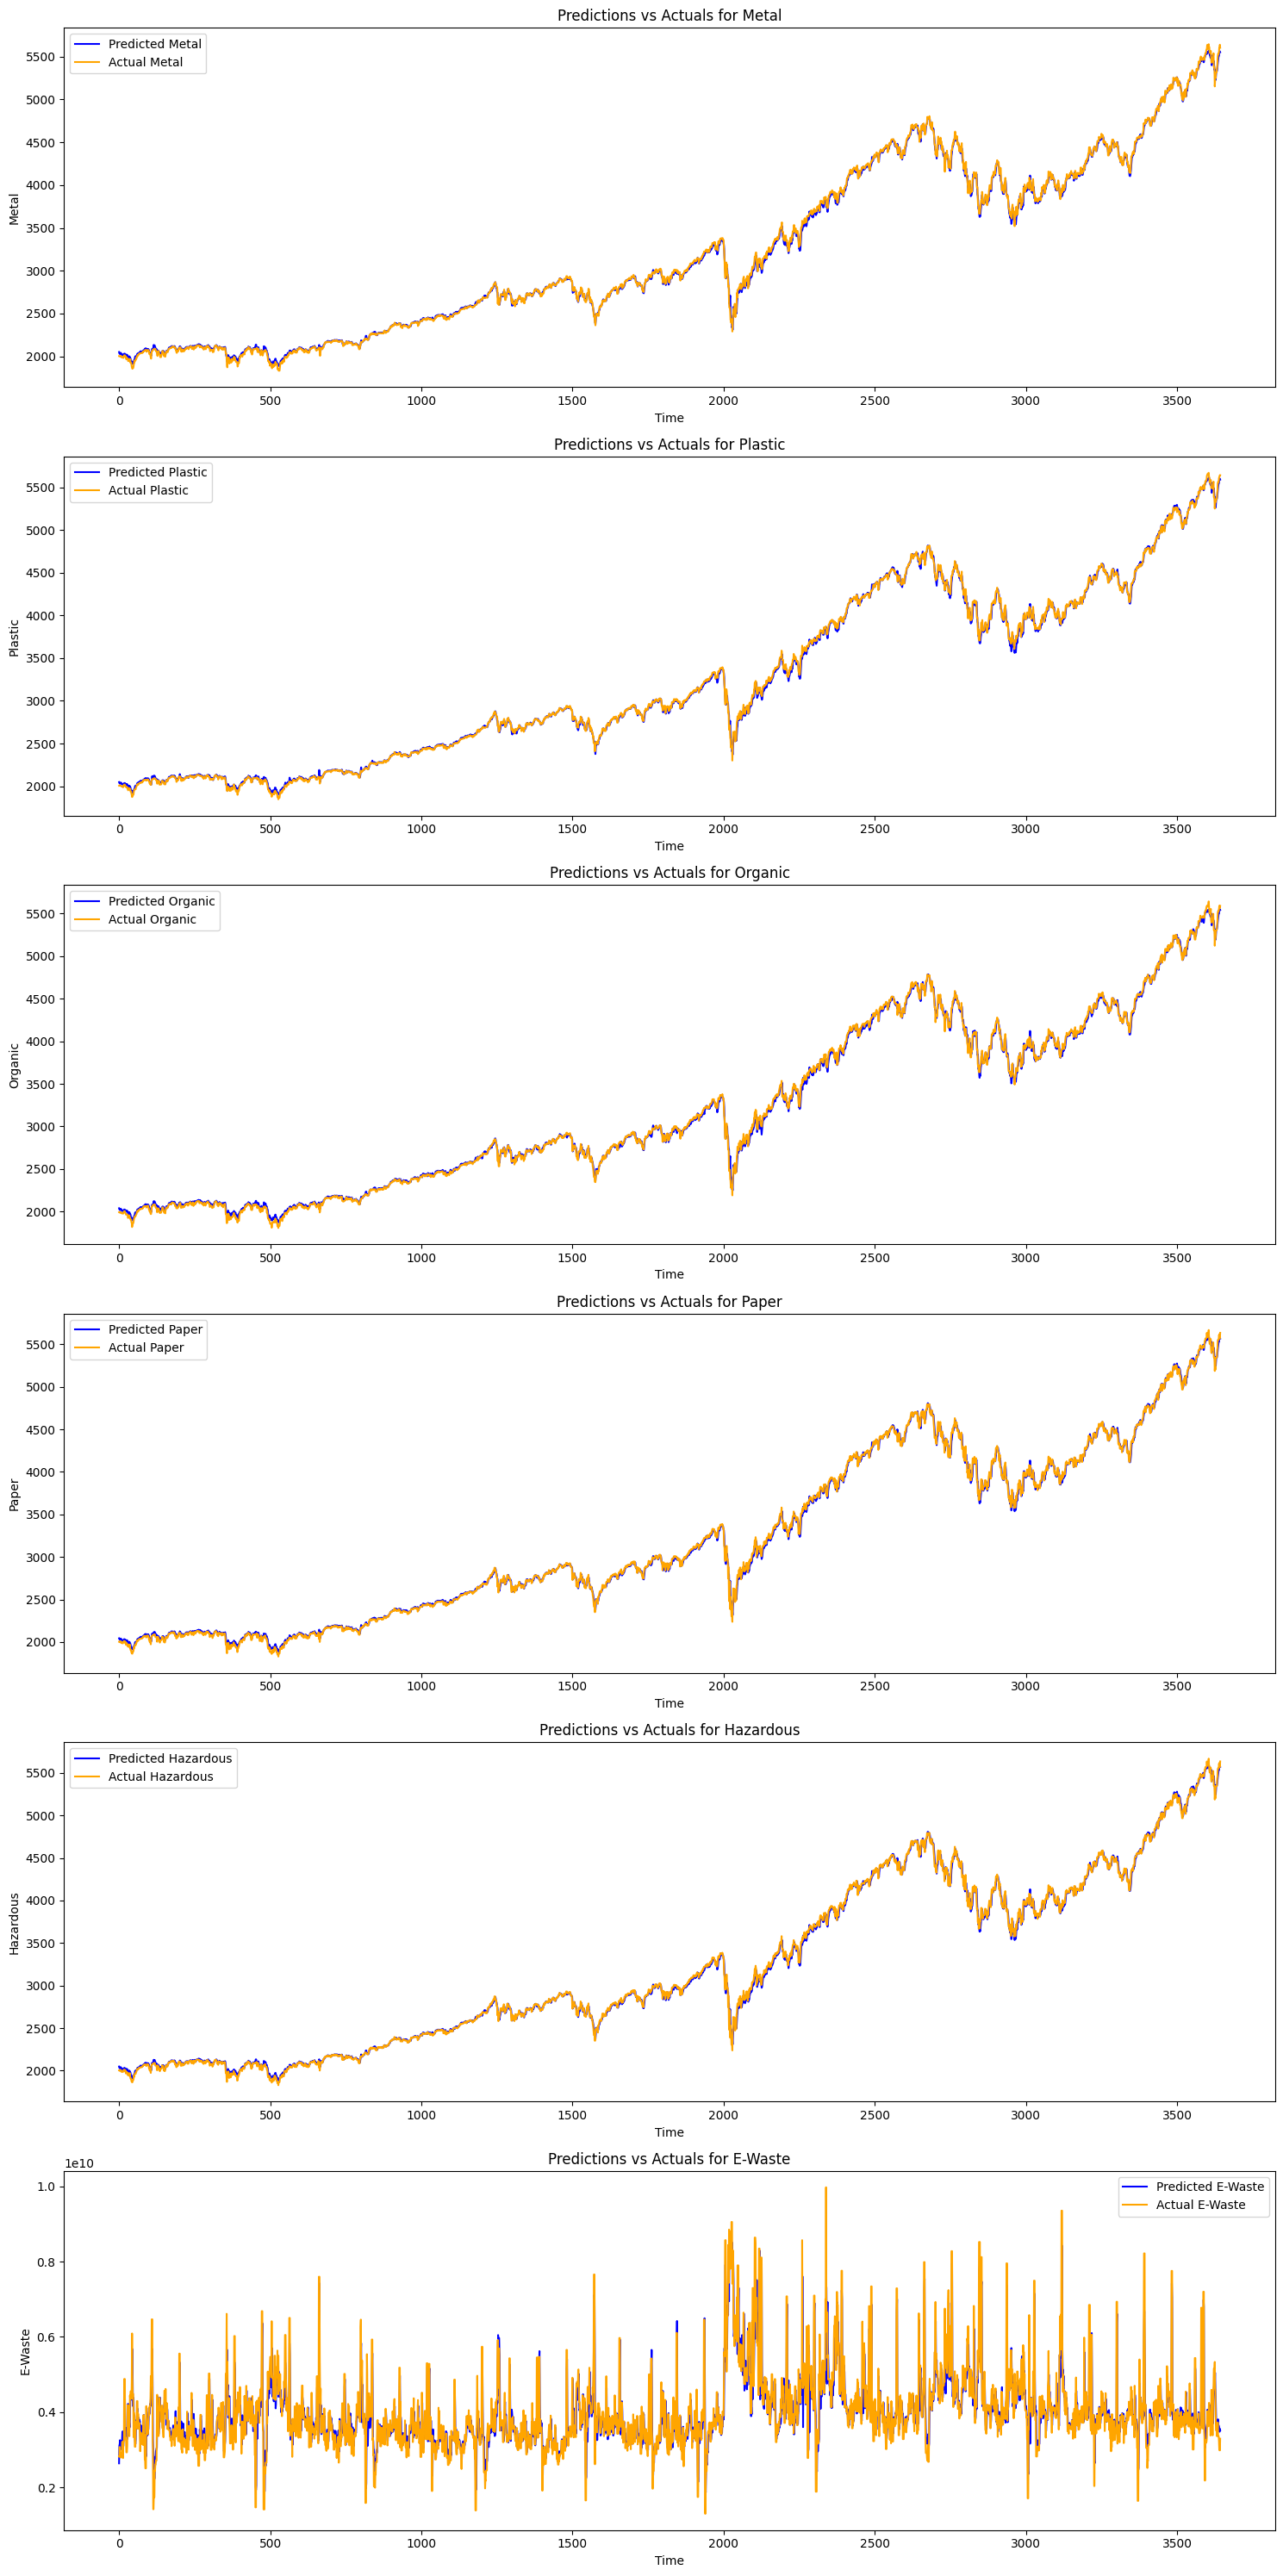

In [20]:
def plot_predictions_vs_actuals(predictions_df, actuals_df, target_columns):
    # Set up the plot for each target column
    num_columns = len(target_columns)
    plt.figure(figsize=(15, 5 * num_columns))  # Adjust figure size based on number of columns

    for i, col in enumerate(target_columns):
        plt.subplot(num_columns, 1, i + 1)
        plt.plot(predictions_df[col], label=f'Predicted {col}', color='blue')
        plt.plot(actuals_df[col], label=f'Actual {col}', color='orange')
        plt.title(f'Predictions vs Actuals for {col}')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel(col)

    plt.tight_layout()
    plt.show()

# Example usage for evaluating the model for each zip code and plotting results
zip_codes = data['ID'].unique()

for zip_code in zip_codes:
    print(f"Evaluating model for Zip Code: {zip_code}")

    # Filter data for the current zip code
    filtered_data = data[data['ID'] == zip_code].drop(columns=['ID'])
    
    # Apply resampling and forward filling for this zip code
    filtered_data = filtered_data.resample('D').asfreq()
    filtered_data = filtered_data.fillna(method='ffill')
    
    # Scale the data for this zip code
    scaled_data, scaler = scale_data(filtered_data, target_columns)
    
    # Create the dataset and DataLoader for this zip code
    dataset = TimeSeriesDataset(df=scaled_data, target_cols=target_columns, n_steps=lookback)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers, output_size=output_size)
    
    # Load the model weights for this zip code
    model_path = f"model_LSTM_weights_{zip_code}.pth"
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # Evaluate the model
    avg_val_loss, predictions_df, actuals_df = evaluate_model(model, test_loader, scaler['scaler'], target_columns, device)

    print(f'Validation Loss for Zip Code {zip_code}: {avg_val_loss:.4f}')
    
    # Plot predictions vs actuals
    plot_predictions_vs_actuals(predictions_df, actuals_df, target_columns)

Predicting next 10 days for Zip Code: 1
Predicted values for the next 10 days for Zip Code 1:

        Metal     Plastic     Organic       Paper   Hazardous      E-Waste
0  131.769150  132.804047  128.746674  129.156525  129.480484  259009104.0
1  129.271637  130.243301  126.380554  126.913177  127.169632  203255744.0
2  121.046814  122.819847  117.474663  119.248535  119.530800  308778112.0
3  108.925949  110.598747  103.922295  106.252235  106.066101  633182848.0
4  108.844360  109.423843  103.443069  104.826241  103.722801  972165504.0
5  113.839279  113.991646  109.339531  111.316414  109.611603  753492800.0
6  116.301651  117.299492  111.873711  114.207260  113.032478  654658560.0
7  118.748184  120.147743  113.830063  115.778992  116.191429  499148256.0
8  117.203926  118.467934  111.955452  113.906250  114.223198  579559232.0
9  116.770561  117.949547  111.477303  113.435646  113.610100  611515776.0


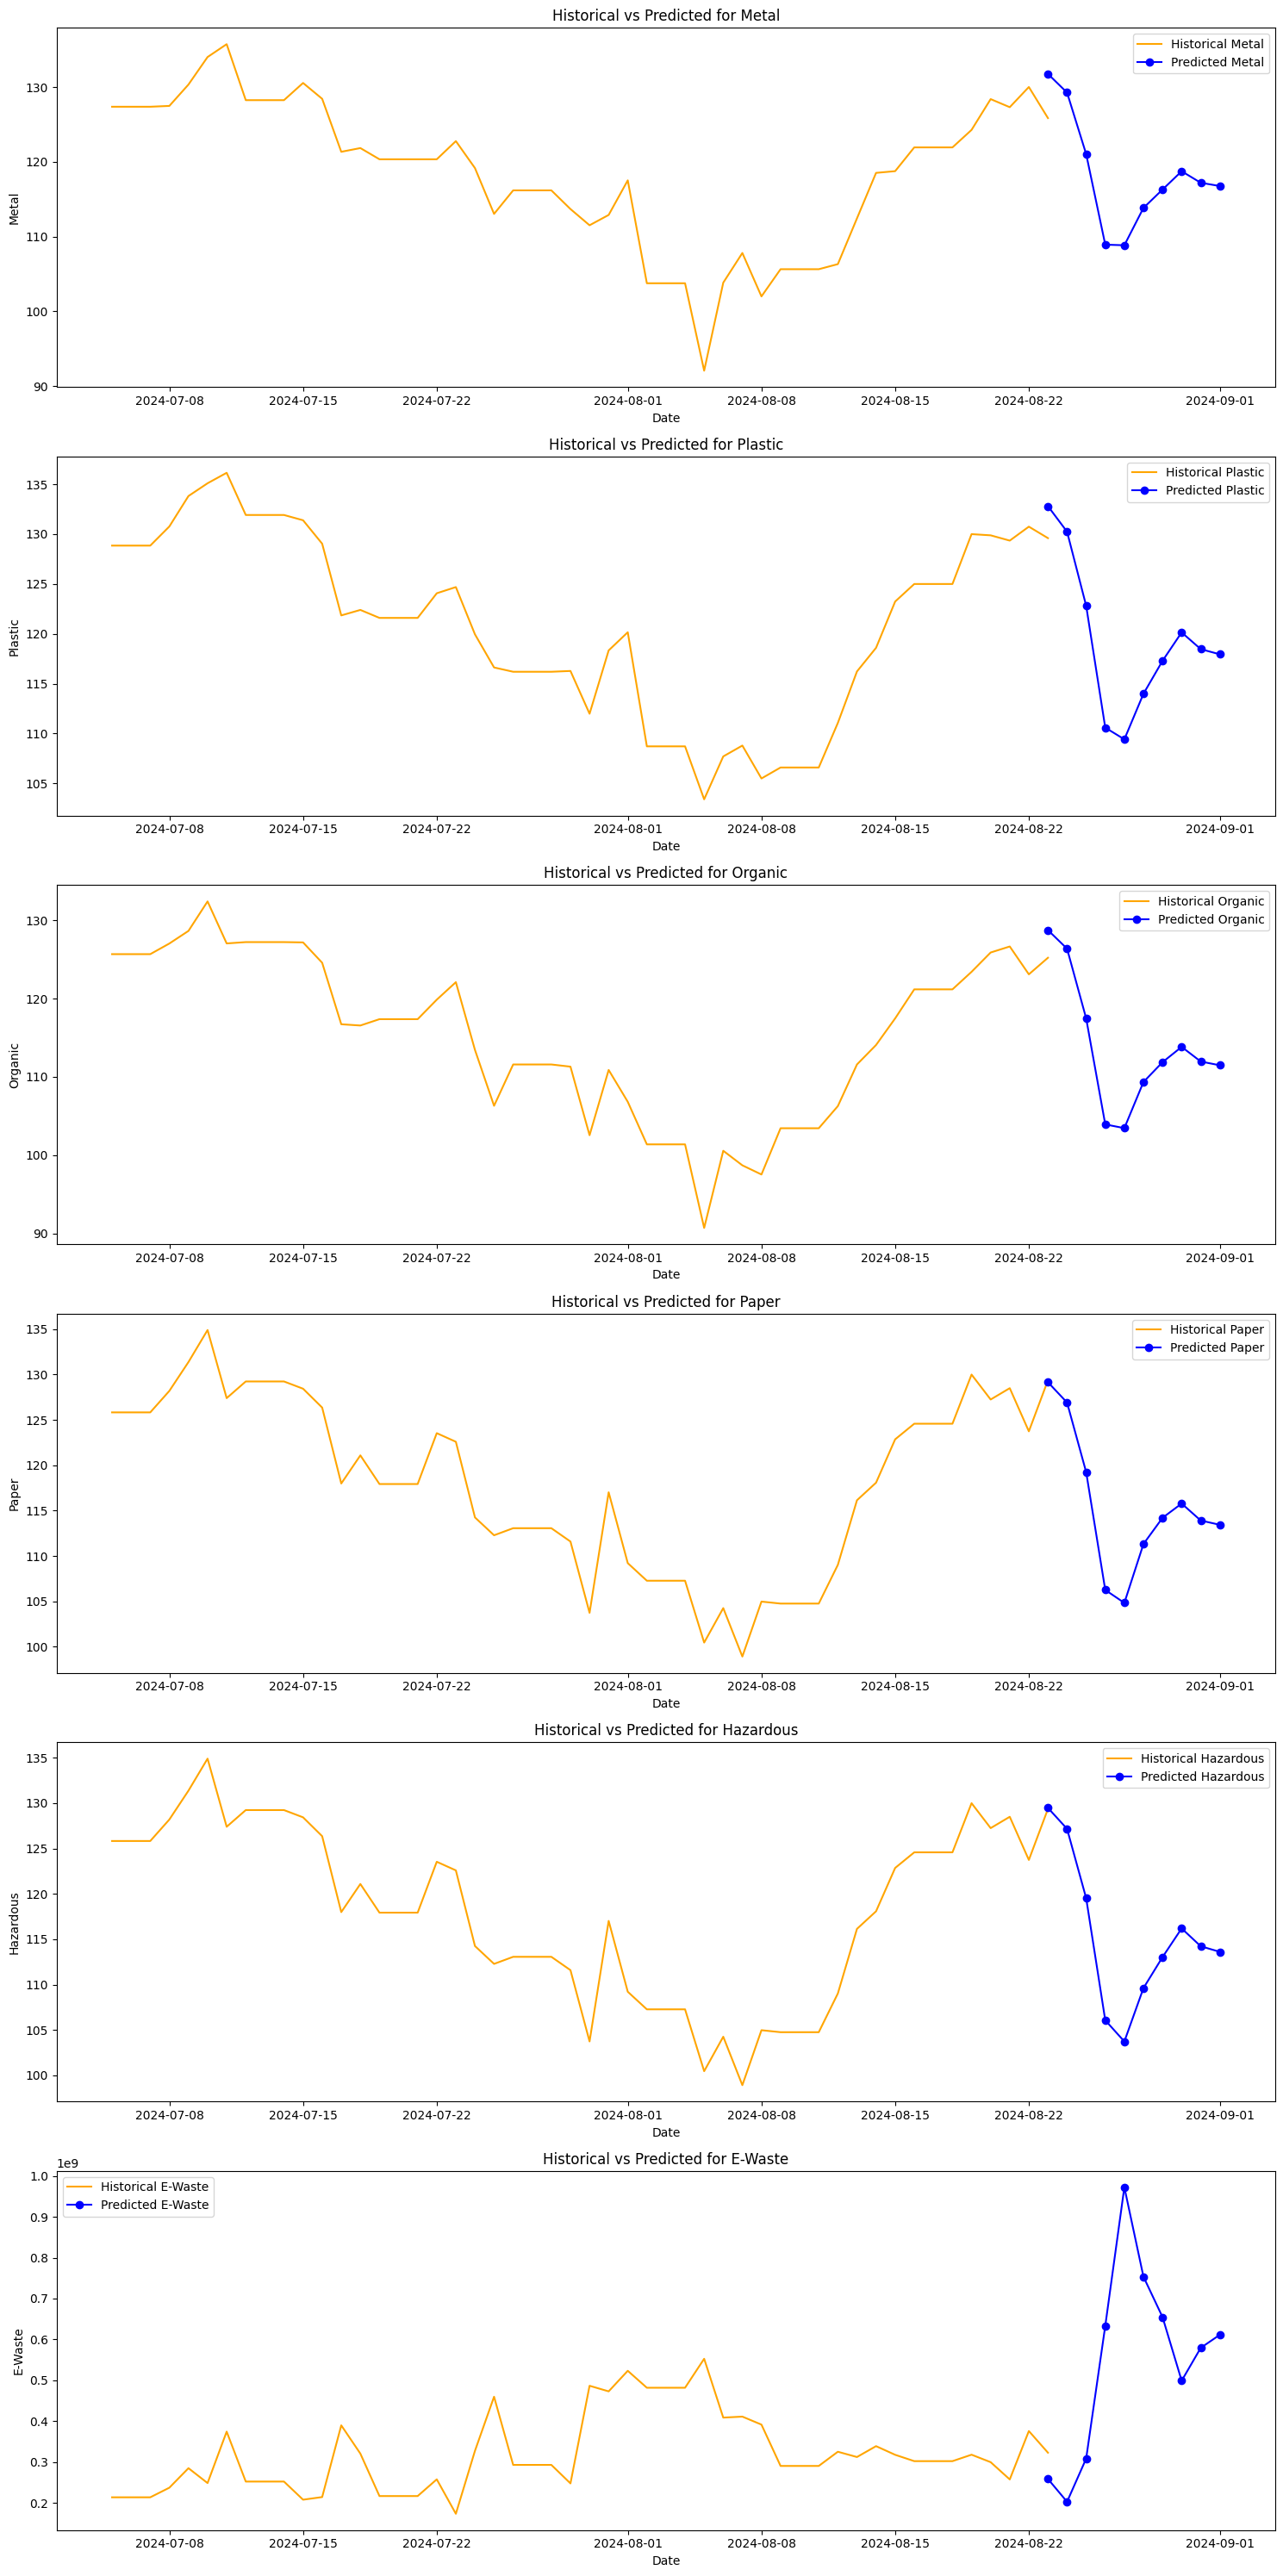

Predicting next 10 days for Zip Code: 2
Predicted values for the next 10 days for Zip Code 2:

         Metal      Plastic      Organic        Paper    Hazardous  \
0  5550.553223  5590.238281  5537.707520  5567.533691  5571.775391   
1  4291.627441  4324.794434  4225.520508  4231.665527  4223.722168   
2  3731.905273  3801.156494  3585.627930  3656.179199  3693.511963   
3  3572.362549  3672.723877  3484.420898  3580.440430  3582.974854   
4  3985.879395  4041.262207  4004.189941  4046.346436  4056.573975   
5  3616.074219  3636.838135  3574.275635  3611.593506  3613.401611   
6  4168.170898  4229.044922  4212.542480  4241.393066  4251.011719   
7  3713.488281  3709.240479  3656.322510  3684.244141  3684.930908   
8  4120.436523  4172.709473  4129.704590  4165.063477  4172.852539   
9  3656.842041  3660.411865  3594.240234  3626.097656  3626.459229   

        E-Waste  
0  3.513684e+09  
1  4.243871e+09  
2  4.762948e+09  
3  7.257174e+09  
4  5.238717e+09  
5  7.179608e+09  
6  5.185

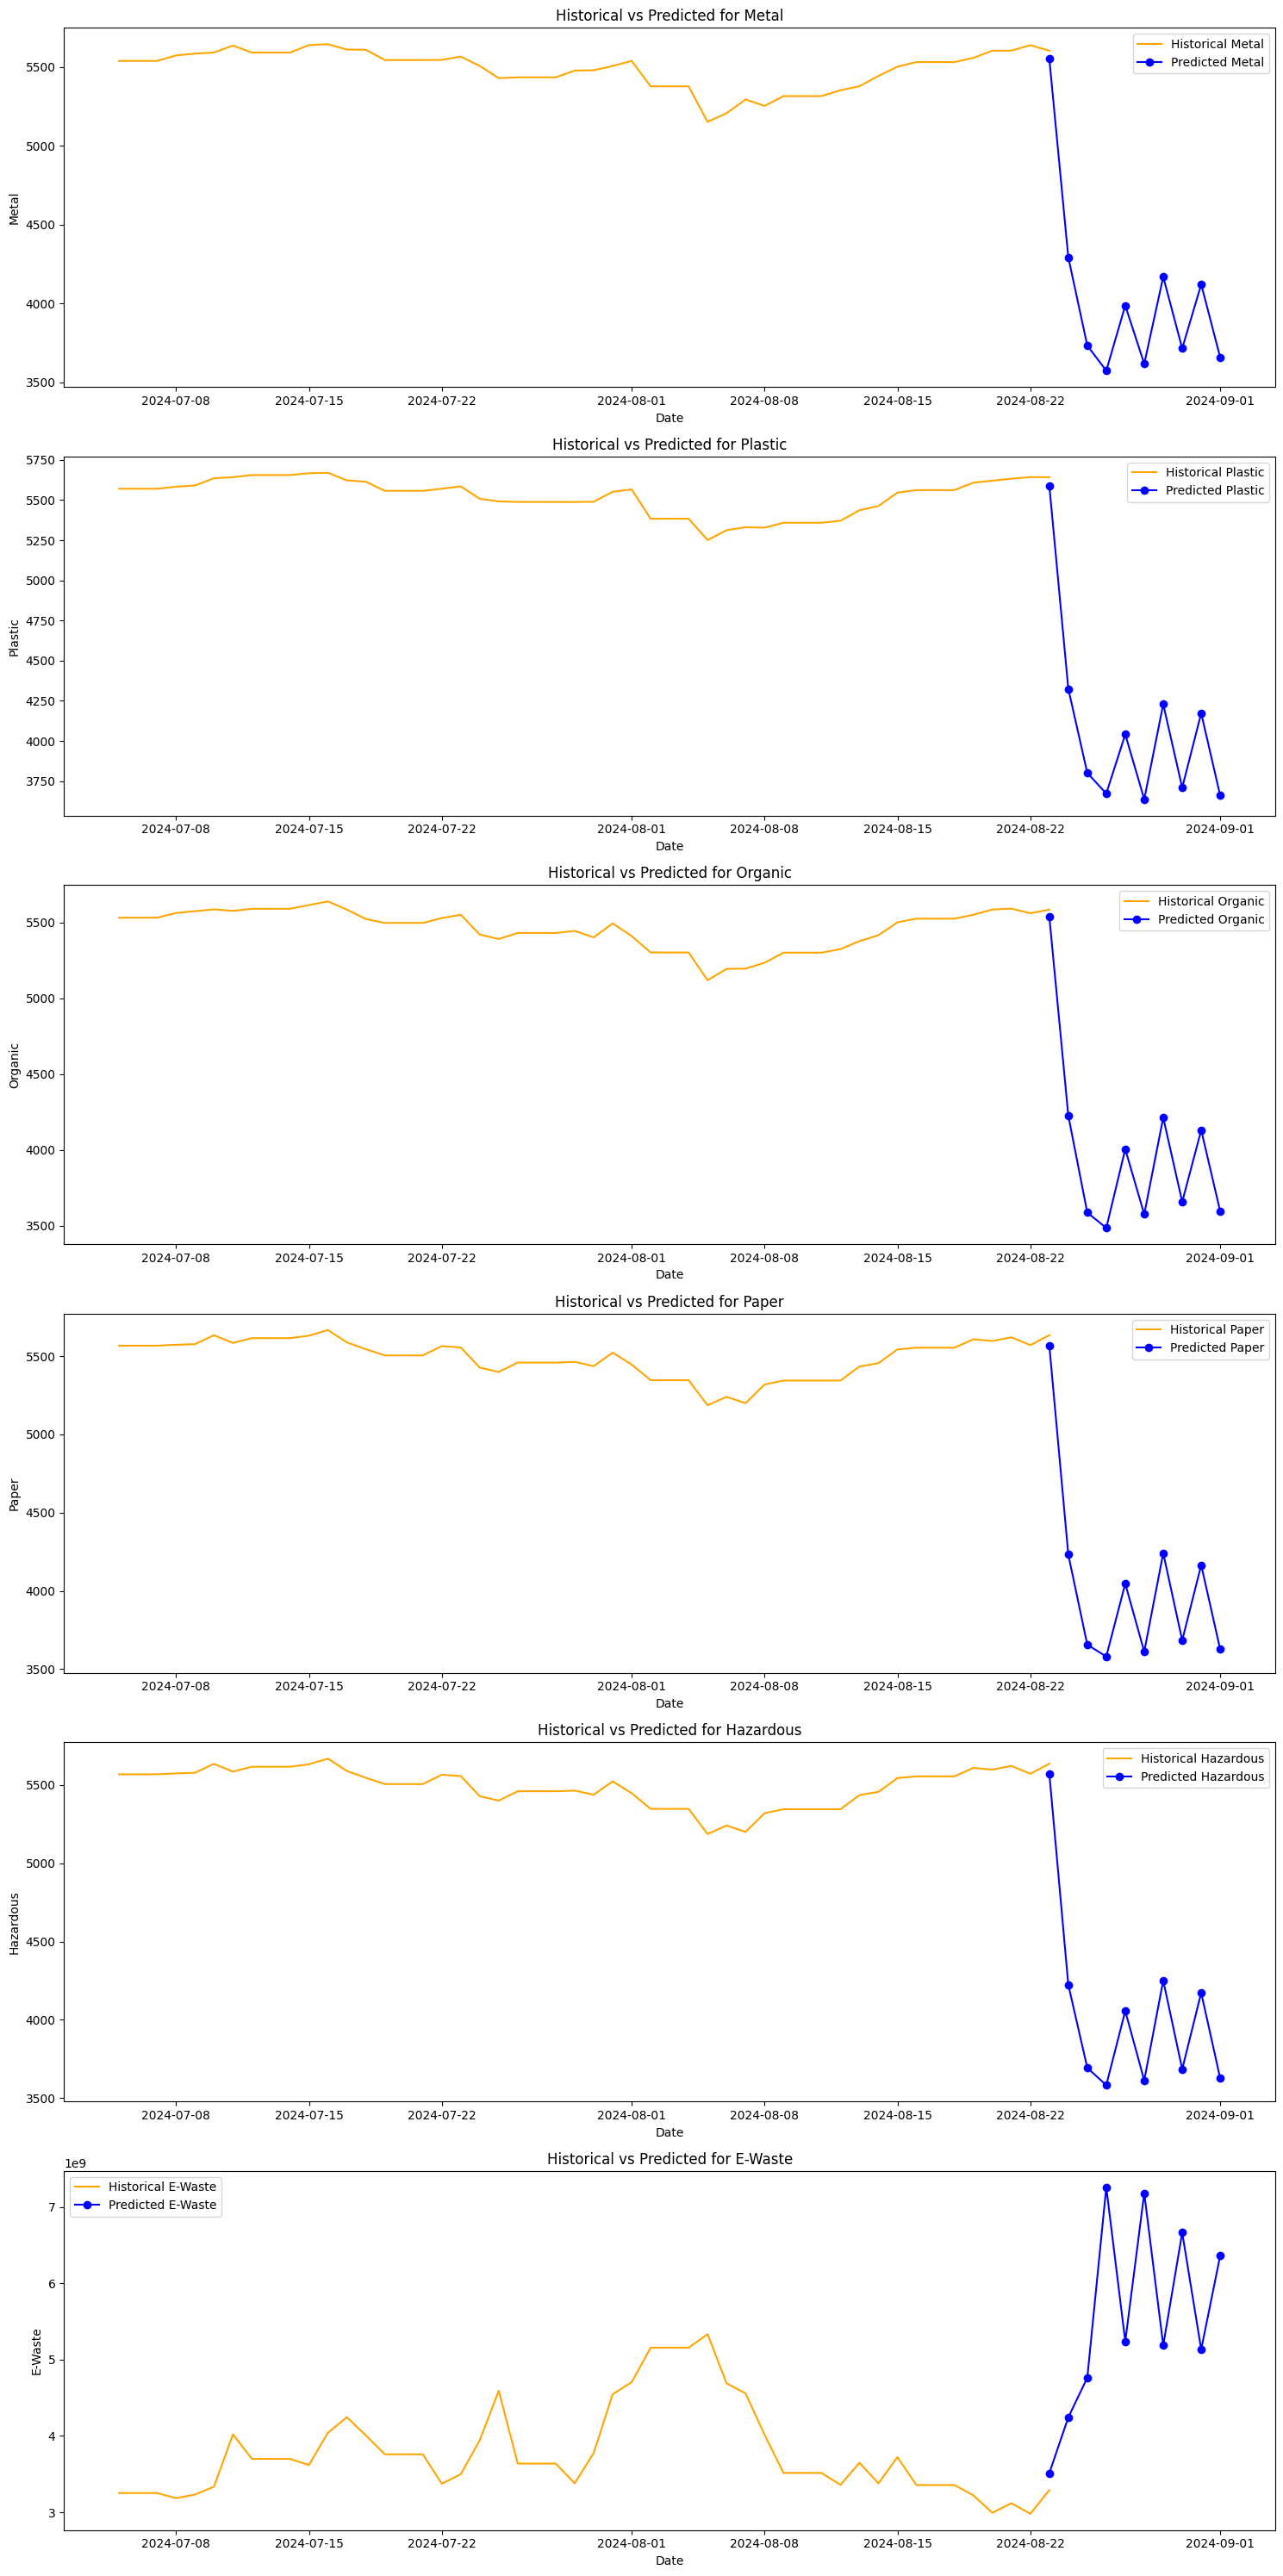

In [21]:
def predict_next_days(model, last_sequence, scaler, target_columns, device, days=10):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    current_sequence = last_sequence

    with torch.no_grad():
        for _ in range(days):
            x_input = torch.tensor(current_sequence, dtype=torch.float32).to(device).unsqueeze(0)
            
            # Generate the prediction
            predicted = model(x_input).cpu().numpy()
            
            # Denormalize the predicted values
            predicted_values = scaler.inverse_transform(predicted).flatten()
            
            # Store the predictions
            predictions.append(predicted_values)
            
            # Update the sequence to include the predicted value (rolling window)
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1] = predicted  # Update the last time step with the predicted values

    # Convert predictions to a DataFrame for easier handling
    predictions_df = pd.DataFrame(predictions, columns=target_columns)

    return predictions_df

def plot_predictions_with_history(data, predictions_df, target_columns):
    num_columns = len(target_columns)
    plt.figure(figsize=(15, 5 * num_columns))

    for i, col in enumerate(target_columns):
        plt.subplot(num_columns, 1, i + 1)
        
        # Plot the historical data
        plt.plot(data.index[-50:], data[col].values[-50:], label=f'Historical {col}', color='orange')
        
        # Plot the predictions
        plt.plot(pd.date_range(data.index[-1], periods=10, freq='D'), predictions_df[col], 
                 label=f'Predicted {col}', color='blue', marker='o')

        plt.title(f'Historical vs Predicted for {col}')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)

    plt.tight_layout()
    plt.show()

# Example usage for predicting the next 10 days for a zip code and plotting results
for zip_code in zip_codes:
    print(f"Predicting next 10 days for Zip Code: {zip_code}")

    # Filter data for the current zip code
    filtered_data = data[data['ID'] == zip_code].drop(columns=['ID'])
    
    # Apply resampling and forward filling for this zip code
    filtered_data = filtered_data.resample('D').asfreq()
    filtered_data = filtered_data.fillna(method='ffill')
    
    # Scale the data for this zip code
    scaled_data, scaler = scale_data(filtered_data, target_columns)
    
    # Create the dataset and DataLoader for this zip code
    dataset = TimeSeriesDataset(df=scaled_data, target_cols=target_columns, n_steps=lookback)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers, output_size=output_size)
    
    # Load the model weights for this zip code
    model_path = f"model_LSTM_weights_{zip_code}.pth"
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # Get the last sequence from the dataset
    last_sequence = dataset[-1][0].cpu().numpy()
    
    # Predict the next 10 days
    predictions_df = predict_next_days(model, last_sequence, scaler['scaler'], target_columns, device, days=10)

    # Display the predictions
    print(f"Predicted values for the next 10 days for Zip Code {zip_code}:\n")
    print(predictions_df)
    
    # Plot the predictions alongside historical data
    plot_predictions_with_history(filtered_data, predictions_df, target_columns)